# 1. Import Data and Python Packages

In [1]:
# Dependencies and setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.tree import plot_tree
import os
%matplotlib inline

In [2]:
# Set maximum rows to a high number
pd.set_option('display.max_rows', 100)

In [3]:
# Load datasets
training_data = pd.read_csv('01-raw_data/train.csv',index_col=0)
testing_data = pd.read_csv('01-raw_data/test.csv',index_col=0)

# 2. Perform Initial Observations and Deal with Missing Values

### 2a. Investigate shape of dataset and whether or not there are any missing values

In [4]:
# Make copies of the original DataFrames in order to prevent errors
training_data_2 = training_data.copy()
testing_data_2 = testing_data.copy()

In [5]:
# Investigate shape of the training dataset
training_data_2.shape

(891, 11)

In [6]:
# Investigate shape of the testing dataset
testing_data_2.shape

(418, 10)

In [7]:
# Investigate missing values in the training dataset
total_missing_training = training_data_2.isnull().sum().sort_values (ascending = False)
percent_missing_training = round((training_data_2.isnull().sum().sort_values(ascending = False)/len(training_data_2))*100,2)
pd.concat([total_missing_training, percent_missing_training], axis = 1, keys = ['Total','Percent'])

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [8]:
# Investigate missing values in the testing dataset
total_missing_testing = testing_data_2.isnull().sum().sort_values (ascending = False)
percent_missing_testing = round((testing_data_2.isnull().sum().sort_values(ascending = False)/len(testing_data_2))*100,2)
pd.concat([total_missing_testing, percent_missing_testing], axis = 1, keys = ['Total','Percent'])

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


The training dataset has 11 fields and 891 observations. The testing dataset has 10 fields and 418 observations. The training dataset includes the field 'Survived' indicating whether or not the passenger survived while the testing dataset does not.

There are missing values in the 'Cabin', 'Age', 'Embarked', and 'Fare' columns. It is important to figure out a strategy to deal with these missing values so that machine learning algorithms will work.

To handle missing values, there are primarily three options:
1. Remove the field entirely
2. Remove the observations that contain the missing values
3. Replace the missing values with approximations of the values

### 2b. Deal with missing 'Fare' values

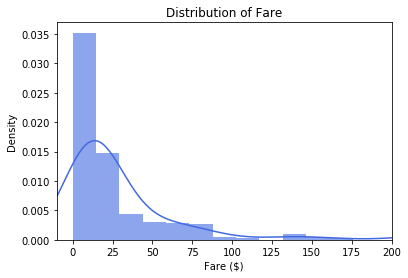

In [9]:
# Plot a histogram of fares in the training dataset
testing_data_2.Fare.hist(bins=35, density = True, stacked = True, alpha = 0.6, color='royalblue')
testing_data_2.Fare.plot(kind = 'density', color = 'royalblue')
plt.xlabel('Fare ($)')
plt.xlim(-10,200)
plt.title('Distribution of Fare')
plt.show()

In [10]:
# Look at the line item with the missing Fare value
testing_data_2[testing_data_2['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [11]:
# Fill in missing Fare values with the median Fare paid by customers of the same passenger class, sex, and port of embarkation
testing_data_2['Fare'] = testing_data_2.groupby(['Pclass','Sex','Embarked'])['Fare'].transform(lambda x: x.fillna(x.median()))

One fare is missing from the test dataset.

**Options for handling missing values:**
1. Remove the field entirely
    - Not a good solution because 'Fare' is a usable field
    - The vast majority of observations for the 'Fare' field are present, making 'Fare' a very usable field that should not be removed
2. Remove the observations that contain the missing values
    - Not a good solution because the missing value exists in the test dataset
    - The goal of the Titanic Problem is to predict whether or not each of the passengers in the test dataset survive. Removing one observation from the test dataset would mean there would be no basis for predicting survivorship for the removed observation
3. Replace the missing values with approximations of the values
    - The best solution in this case

**Strategy for replacing the missing fare value:**

'Fare' is a right skewed variable so it is preferable to replace the missing value with a median value rather than an average value so that the approximation is not overestimated. Ideally, the fare approximation should be based on a the fare paid by a set of passengers similar to the passenger whose fare paid is unknown. In this case, it is a good solution to replace the missing fare with the median fare paid by passengers with the same ticket class, sex, and port of embarkation as the passenger whose fare paid is unknown.

### 2c. Deal with missing 'Embarked' values

In [12]:
# Look into what the 'Embarked' null rows look like
training_data_2[training_data_2['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
# Check if there are any other passengers with the same ticket number in the training dataset
training_data_2[training_data_2['Ticket']=='113572']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
# Check if there are any other passengers with the same ticket number in the testing dataset
testing_data_2[testing_data_2['Ticket']=='113572']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


In [15]:
# Check if there are any other passengers with the same cabin in the training dataset
training_data_2[training_data_2['Cabin']=='B28']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [16]:
# Check if there are any other passengers with the same cabin in the testing dataset
testing_data_2[testing_data_2['Cabin']=='B28']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


In [17]:
# Look at the percentiles of fare prices paid for all first class women
training_data_2[(training_data_2['Pclass'] == 1) & (training_data_2['Sex'] == 'female')].groupby('Embarked')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,43.0,115.640309,88.571645,27.7208,69.3,83.1583,134.500000,512.3292
Q,1.0,90.000000,NaN,90.0000,90.0,90.0000,90.000000,90.0000
S,48.0,99.026910,61.094407,25.9292,53.1,79.6500,139.612475,263.0000


In [18]:
# Look into the most common port of embarkation for people on cabin level B
training_data_2[training_data_2['Cabin'].str[0]=='B']['Embarked'].value_counts()

S    23
C    22
Name: Embarked, dtype: int64

In [19]:
# Look at the most common ticket classes for individuals on cabin level B
training_data_2[training_data_2['Cabin'].str[0]=='B']['Pclass'].value_counts()

1    47
Name: Pclass, dtype: int64

In [20]:
# Look at the distribution of sexes of passengers inhabiting cabin level B 
training_data_2[training_data_2['Cabin'].str[0]=='B']['Sex'].value_counts()

female    27
male      20
Name: Sex, dtype: int64

In [21]:
# Look at the percentiles of fare prices paid by women inhabiting cabin level B
training_data_2[(training_data_2['Cabin'].str[0]=='B') & (training_data_2['Sex'] == 'female')].groupby('Embarked')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,12.0,124.014233,87.994021,27.7208,57.9792,80.1896,171.7708,262.3750
S,13.0,113.731731,60.386313,30.0000,86.5000,93.5000,120.0000,211.3375


In [22]:
# Replace the missing 'Embarked' datapoints with 'C' for 'Cherbourg'
training_data_2.update(training_data_2['Embarked'].fillna('C'))

Two passengers have missing port of embarkation values in the training dataset.

**Options for handling missing values:**
1. Remove the field entirely
    - Not a good solution because 'Embarked' is a usable field
    - The vast majority of observations for the 'Embarked' field are present, making 'Embarked' a very usable field that should not be removed
2. Remove the observations that contain the missing values
    - A valid solution, but not the best solution because it is important to have as many usable training observations as possible
    - Since the training dataset is already relatively small, observations should not be removed unless it is absolutely necessary
3. Replace the missing values with approximations of the values
    - The best solution in this case

**Strategy for replacing the missing port of embarkation values:**

Both of the passengers with missing port of embarkation values have the same ticket number and cabin number. Both passengers are female first class passengers who paid the same fare. Both women reside on cabin floor B. No other passengers on the ship have the same ticket number as the two women with missing port of embarkation values, but several reside on the same cabin floor. 

First class women residing on cabin floor B who embarked from 'Cherbourg' generally paid fairs most similar to those of the two women with missing port of embarkation values. Therefore, it is best to replace the null port of embarkation values with 'C' for 'Cherbourg'.

### 2d. Deal with missing 'Age' values

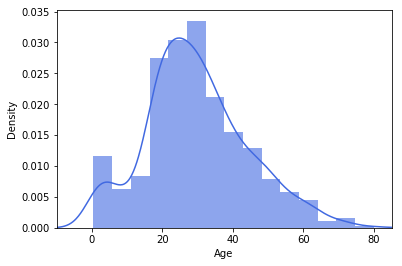

In [23]:
# Plot a histogram of ages in the training dataset
training_data_2.Age.hist(bins=15, density = True, stacked = True, alpha = 0.6, color='royalblue')
training_data_2.Age.plot(kind = 'density', color = 'royalblue')
plt.xlabel('Age')
plt.xlim(-10,85)
plt.show()

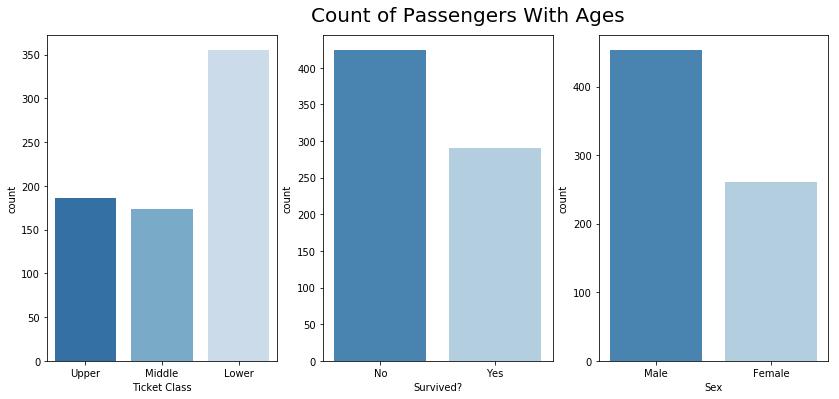

In [24]:
# CREATE A FIGURE SHOWING THE COUNT OF PASSENGERS WITH AGE VALUES POPULATED BY CLASS, SURVIVORSHIP, AND SEX
# Set up the figure with two subplots
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the count of passengers who survived and did not survive
sns.countplot(x = 'Survived', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis2)
axis2.set_xticklabels(['No','Yes'])
axis2.set_xlabel('Survived?')
# Create a plot showing the count of observations by sex
sns.countplot(x = 'Sex', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis3)
axis3.set_xticklabels(['Male','Female'])
axis3.set_xlabel('Sex')
# Add title and show the graph
plt.text(-3, 495, 'Count of Passengers With Ages', fontsize = 20)
plt.show()

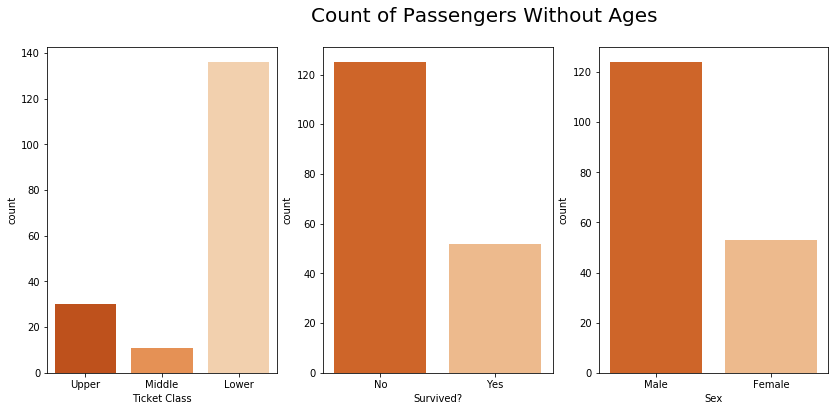

In [25]:
# CREATE A FIGURE SHOWING THE COUNT OF PASSENGERS WITH AGE VALUES EQUAL TO NULL BY CLASS, SURVIVORSHIP, AND SEX
# Set up the figure with two subplots
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the count of passengers who survived and did not survive
sns.countplot(x = 'Survived', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['No','Yes'])
axis2.set_xlabel('Survived?')
# Create a plot showing the count of observations by sex
sns.countplot(x = 'Sex', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis3)
axis3.set_xticklabels(['Male','Female'])
axis3.set_xlabel('Sex')
# Add title and show the graph
plt.text(-3, 140, 'Count of Passengers Without Ages', fontsize = 20)
plt.show()

In [26]:
# Replace missing variables with the median of age for individuals grouped by ticket class, sex, and embarked location
training_data_2['Age'] = training_data_2.groupby(['Pclass','Sex','Embarked'])['Age'].transform(lambda x: x.fillna(x.median()))
testing_data_2['Age'] = testing_data_2.groupby(['Pclass','Sex','Embarked'])['Age'].transform(lambda x: x.fillna(x.median()))

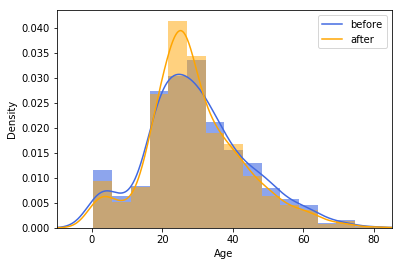

In [27]:
# Plot histogram of ages before nulls were replaced and show this histogram in blue
training_data.Age.hist(bins=15, density = True, stacked = True, alpha = 0.6, color='royalblue')
training_data.Age.plot(kind = 'density', color = 'royalblue', label = 'before')
# Plot histogram of ages after null values were replaced and show the histogram in orange
training_data_2.Age.hist(bins=15, density = True, stacked = True, alpha = 0.5, color='orange')
training_data_2.Age.plot(kind = 'density', color = 'orange', label = 'after')
# Create legend and labels
plt.legend()
plt.xlabel('Age')
plt.xlim(-10,85)
plt.show()

~20% of the age values are missing from both the training and testing datasets.

**Options for handling missing values:**
1. Remove the field entirely
    - Not a good solution because 'Age' is likely a significant field
    - During the Titanic Disaster, efforts were made to save children first so it is likely that age is an important field that helps determine survivorship. As a result, this field should not be removed
2. Remove the observations that contain the missing values
    - Not a good solution because this would mean removing a significant portion of the data
    - Removing ~20% of the data, would likely adversely impact the model's predictive power because the model would have fewer examples of data points to train on
    - Additionally, removing ~20% of the data would mean losing visibility on ~20% of the test observations meaning there would be little basis for predicting survivorship for ~20% of the test observations
3. Replace the missing values with approximations of the values
    - The best solution in this case

**Strategy for replacing the missing age values:**

The age variable is right skewed so it is preferable to replace the missing value with a median value rather than an average value so that the approximation is not overestimated. Ideally, the age approximation should be based on a the age of a set of passengers similar to the passengers whose ages are unknown. In this case, it is a good solution to replace the missing ages with the median ages of passengers with the same ticket class, sex, and port of embarkation as the passengers whose ages are unknown. The histogram above shows the distribution of ages before and after replacements are made. This histogram shows that the distribution of ages is largely preserved after these replacements are made.

### 2e. Deal with missing 'Cabin' values

~77% of the cabin number values are missing from both the training and testing datasets.

**Options for handling missing values:**
1. Remove the field entirely
    - The best solution in this case
2. Remove the observations that contain the missing values
    - Not a good solution because this would mean removing a significant portion of the data
    - Removing ~77% of the data, would adversely impact the model's predictive power because the model would have significantly fewer examples to train on
    - Removing ~77% of the data would also mean losing visibility on ~77% of the test observations meaning there would be little basis for predicting Survivorship for the removed test observations
3. Replace the missing values with approximations of the values
    - Not a good solution because only ~23% of the observations have cabin numbers
    - Given that very few observations have cabin numbers recorded, it would be very difficult to reaonably approximate the cabin numbers for the remaining ~77% of the data

# 3. Explore Variables and their Impact on Survival

### 3a. Explore Ticket Class

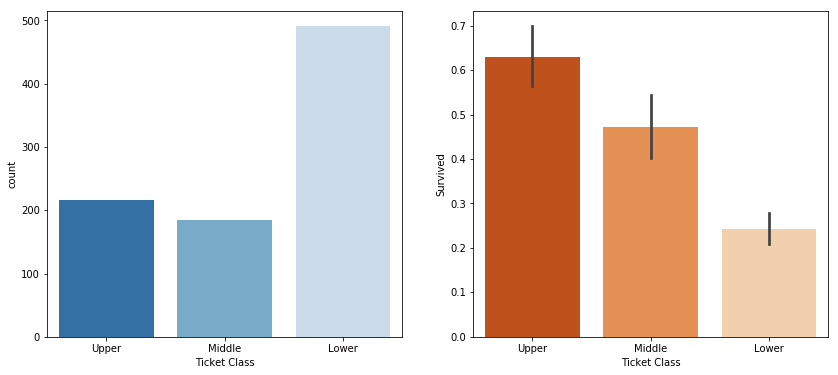

In [28]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the proportion of people in each class who survived
sns.barplot('Pclass', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['Upper','Middle','Lower'])
axis2.set_xlabel('Ticket Class')
plt.show()

Lower class ticket holders make up the bulk of the training dataset relative to middle and upper class ticket holders. People of higher classes tend to be more likely to survive the shipwreck.

### 3b. Expore Gender

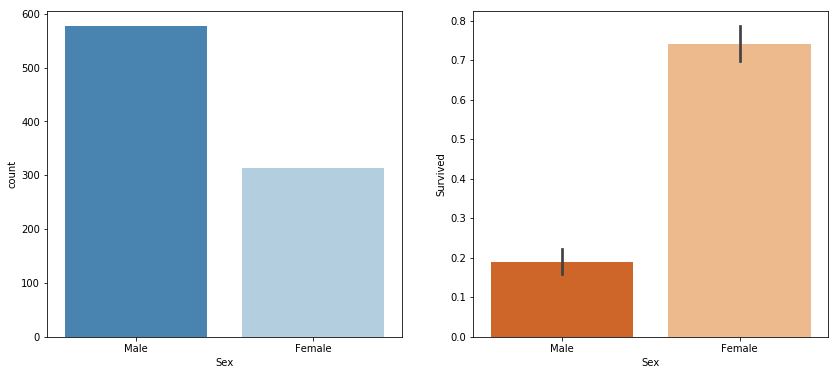

In [29]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Sex', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Male','Female'])
axis1.set_xlabel('Sex')
# Create a plot showing the proportion of people in each class who survive
sns.barplot('Sex', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['Male','Female'])
axis2.set_xlabel('Sex')
plt.show()

The dataset is composed of significantly more men than women. Women were much more likely to survive the shipwreck than men.

### 3c. Explore Age

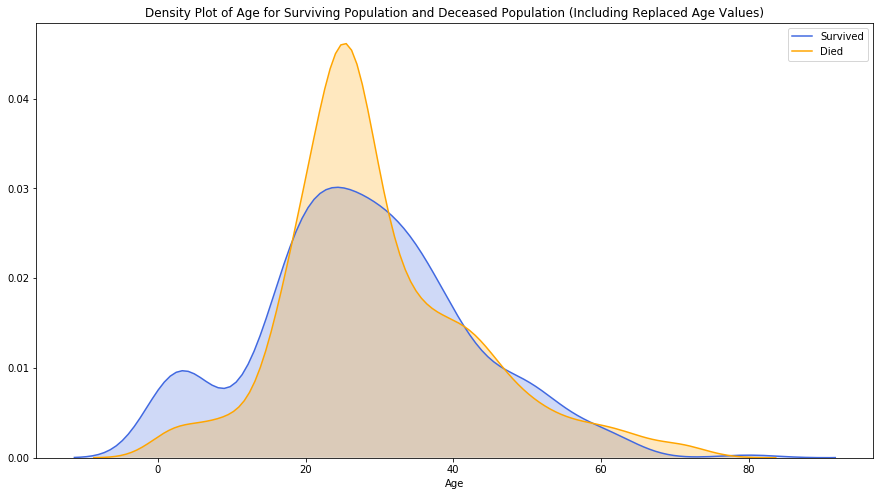

In [30]:
# Set up figure with two subplots
plt.figure(figsize=(15,8))
# Create a kernel density estimation plot showing the ages of passengers who survive the shipwreck and color the plot blue
ax1 = sns.kdeplot(training_data_2['Age'][training_data_2.Survived == 1], color = 'royalblue', shade=True)
# Create a kernel density estimation plot showing the ages of passengers who did not survive the shipwreck and color the plot orange
ax2 = sns.kdeplot(training_data_2['Age'][training_data_2.Survived == 0], color = 'orange', shade=True)
# Add titles and legend
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population (Including Replaced Age Values)')
ax2.set(xlabel = 'Age')
plt.show()

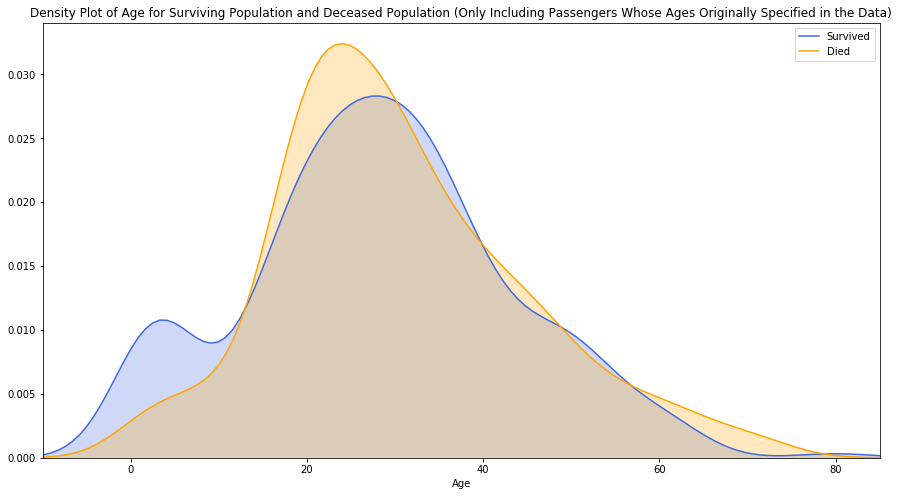

In [31]:
# Set up figure with two subplots
plt.figure(figsize=(15,8))
# Create a kernel density estimation plot showing the ages of passengers who survive the shipwreck and color the plot blue
ax1 = sns.kdeplot(training_data['Age'][(training_data.Age.notnull()) & (training_data.Survived == 1)], color = 'royalblue', shade=True)
# Create a kernel density estimation plot showing the ages of passengers who did not survive the shipwreck and color the plot orange
ax2 = sns.kdeplot(training_data['Age'][(training_data.Age.notnull()) & (training_data.Survived == 0)], color = 'orange', shade=True)
# Add titles and legend
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population (Only Including Passengers Whose Ages Originally Specified in the Data)')
ax2.set(xlabel = 'Age')
plt.xlim(-10,85)
plt.show()

In [32]:
# Look at average survival and count of passengers by age
training_data_2[['Age', 'Survived']].groupby(['Age'], as_index = False).agg(['mean', 'count'])

Survived      
           mean count
Age                  
0.42   1.000000     1
0.67   1.000000     1
0.75   1.000000     2
0.83   1.000000     2
0.92   1.000000     1
1.00   0.714286     7
2.00   0.300000    10
3.00   0.833333     6
4.00   0.700000    10
5.00   1.000000     4
6.00   0.666667     3
7.00   0.333333     3
8.00   0.500000     4
9.00   0.250000     8
10.00  0.000000     2
11.00  0.250000     4
12.00  1.000000     1
13.00  1.000000     2
14.00  0.500000     6
14.25  0.571429     7
14.50  0.000000     1
15.00  0.800000     5
16.00  0.352941    17
17.00  0.461538    13
18.00  0.346154    26
19.00  0.360000    25
20.00  0.578947    38
20.50  0.000000     1
21.00  0.208333    24
22.00  0.407407    27
23.00  0.259259    27
23.50  0.000000     1
24.00  0.500000    30
24.50  0.000000     1
25.00  0.135135    74
26.00  0.250000    36
27.00  0.302326    43
28.00  0.280000    25
28.50  0.000000     2
29.00  0.428571    21
29.50  0.500000     2
30.00  0.363636    33
30.50  0.000000     2
31.00  0.470588    17
32.00  0.500000    18
32.50  0.500000     2
33.00  0.526316    19
34.00  0.400000    15
34.50  0.000000     1
35.00  0.611111    18
36.00  0.500000    22
36.50  0.142857     7
37.00  0.166667     6
38.00  0.625000    16
39.00  0.357143    14
40.00  0.461538    13
40.50  0.000000     2
41.00  0.333333     6
42.00  0.357143    28
43.00  0.200000     5
44.00  0.333333     9
45.00  0.416667    12
45.50  0.000000     2
46.00  0.000000     3
47.00  0.111111     9
48.00  0.666667     9
49.00  0.666667     6
50.00  0.500000    10
51.00  0.285714     7
52.00  0.500000     6
53.00  1.000000     1
54.00  0.375000     8
55.00  0.500000     2
55.50  0.000000     1
56.00  0.500000     4
57.00  0.000000     2
58.00  0.600000     5
59.00  0.000000     2
60.00  0.500000     4
61.00  0.000000     3
62.00  0.500000     4
63.00  1.000000     2
64.00  0.000000     2
65.00  0.000000     3
66.00  0.000000     1
70.00  0.000000     2
70.50  0.000000     1
71.00  0.000000     2
74.00  0.000000     1
80.00  1.000000     1

In the above graphs, density curves are used to show the different distributions of ages for passengers who survive the shipwreck and passengers who do not survive the shipwreck. The goal is to see whether or not the distribution of ages of the surviving population is different than the distribution of ages of the deceased population. If the distributions are different, it could mean that age plays a role in indicating a passenger's probability of surviving the shipwreck.

The first graph (titled 'Density Plot of Age for Surviving Population and Deceased Population (Including Replaced Age Values)') compares the distribution of ages for passengers who survive the shipwreck relative to passengers who do not survive the shipwreck. Note that in the first graph, the age distribution for deceased passengers and surviving passengers differs in two ways:

    1. A higher proportion of surviving individuals are between the ages of ~0 and ~18
    2. A higher proportion of deceased passengers are between the ages of ~18 and ~35
    
The second difference is due to the methodology used to replace null ages. Null ages are replaced by median values grouped by different factors. Since passengers with missing age values tend to disproportionately exist in the deceased group, when missing values are replaced it slightly throws off the distribution of ages for deceased passengers. When the observations with missing ages are ignored, the deceased and surviving groups have similar distributions of ages apart from the ~0 - ~18 age group.

The key takeaway is that it appears that children are more likely to survive the shipwreck than adults. 

### 3d. Explore Sibling/Spouses On Board the Titanic

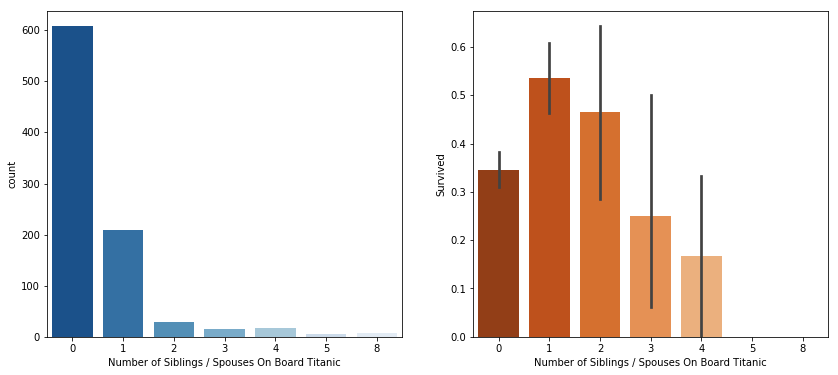

In [33]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of siblings / spouses on board the titanic
sns.countplot(x = 'SibSp', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Number of Siblings / Spouses On Board Titanic')
# Create a plot showing the proportion of with different numbers of siblings / spouses onboard the titanic who survive
sns.barplot('SibSp', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Number of Siblings / Spouses On Board Titanic')
plt.show()

The vast majority of passengers in the training dataset do not have a sibling or spouse on board the Titanic.

There seems to generally be higher survivorship for passengers traveling with one or more siblings or spouses relative to passengers traveling without any siblings or spouses.

### 3e. Explore Parents/Children On Board the Titanic

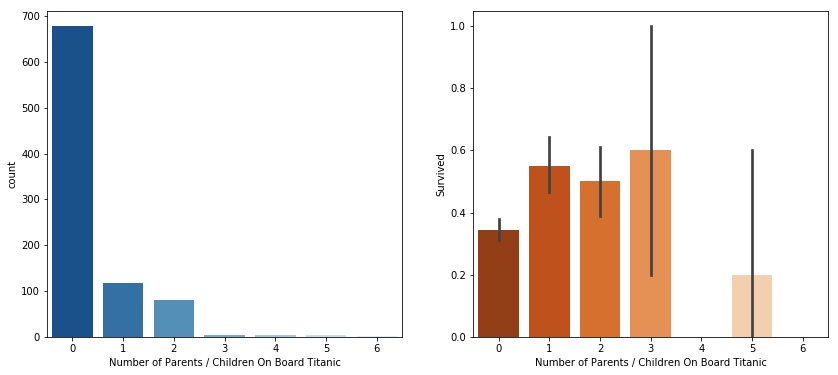

In [34]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'Parch', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Number of Parents / Children On Board Titanic')
# Create a plot showing the proportion of with different numbers of parents / children onboard the titanic who survive
sns.barplot('Parch', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Number of Parents / Children On Board Titanic')
plt.show()

The vast majority of passengers in the training dataset do not have a parent or child on board the Titanic.

There seems to generally be higher survivorship for passengers traveling with one or more parents or children relative to passengers traveling without any parents or children.

### 3f. Explore Fare

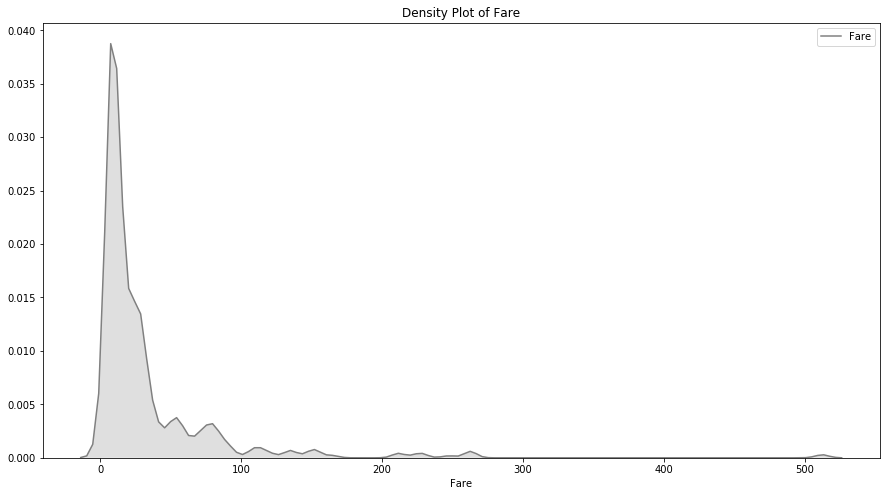

In [35]:
# Create a density plot showing the distribution of fares passengers paid
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['Fare'], color='grey', shade=True)
plt.title('Density Plot of Fare')
ax1.set(xlabel = 'Fare')
plt.show()

In [36]:
# Create a pivot table showing the counts of passengers per ticket number
training_data_3 = training_data_2.copy()
training_data_3.drop(columns = ['Survived'], inplace = True)
combined_data = training_data_3.append(testing_data_2)
ticket_counts = combined_data.pivot_table(index = 'Ticket', values = ['Name'], aggfunc = {'Name':'count'})
ticket_counts = ticket_counts.rename(columns = {'Name': 'TicketCount'})

In [37]:
# Merge the dataset with the pivot table in order to add a column showing the number of passengers assigned to the observation's ticket number
training_data_2 = training_data_2.merge(ticket_counts, left_on='Ticket', right_on = 'Ticket')

In [38]:
# Look at the dataset with the new column added to see if ticket fares correspond to individual passengers or to all passengers in groups with the same ticket number
training_data_2.sort_values(by=['TicketCount'], ascending = False).head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketCount
245,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
244,0,3,"Sage, Mr. Douglas Bullen",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
243,0,3,"Sage, Miss. Stella Anna",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
242,0,3,"Sage, Mr. George John Jr",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
241,0,3,"Sage, Mr. Frederick",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
240,0,3,"Sage, Miss. Constance Gladys",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
239,0,3,"Sage, Master. Thomas Henry",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
104,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S,8
134,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,8
132,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,8


In [39]:
# Drop the new ticket count column -- feature engineering is handled later in this notebook
training_data_2.drop(columns = ['TicketCount'], inplace = True)

A density plot of passenger fares shows a right skewed variable with some passengers paying more than $100 for tickets. Upon closer investigation, it is clear that passenger fare corresponds to the ticket number not to the individual passenger. So if passengers purchase tickets in a group, the fare applies to the fees paid by the entire group and not to the individual passengers. This issue is resolved in the feature engineering section of this notebook.

### 3g. Explore Port of Embarkation

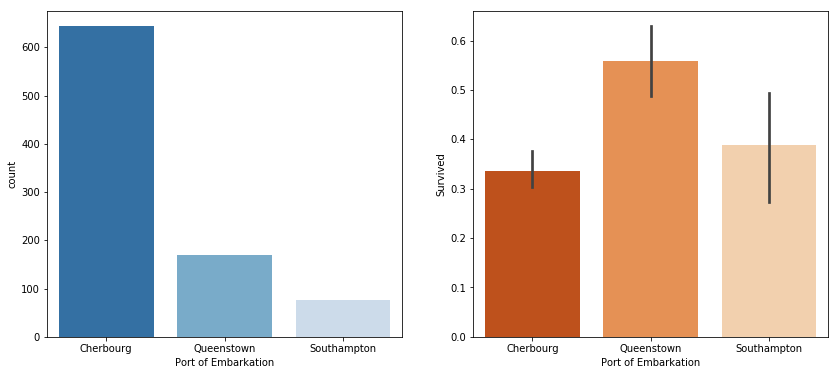

In [40]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations of passengers leaving from different ports
sns.countplot(x = 'Embarked', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Port of Embarkation')
axis1.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
# Create a plot showing the proportion of with different numbers of passengers leaving from different ports who survive
sns.barplot('Embarked', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Port of Embarkation')
axis2.set_xticklabels(['Cherbourg','Queenstown', 'Southampton'])
plt.show()

The vast majority of passengers leave from Cherbourg. It appears that passengers from some ports have higher survivorship than others.

# 4. Feature Engineering

### 4a. Isolate the Effect of Age

In [41]:
# Define children as under 16 and adults as older than 16 or older
training_data_2['ChildAdult'] = pd.cut(training_data_2['Age'],[0,16,81],  labels = ['child', 'adult'], right = False)
testing_data_2['ChildAdult'] = pd.cut(testing_data_2['Age'],[0,16,81],  labels = ['child', 'adult'], right = False)

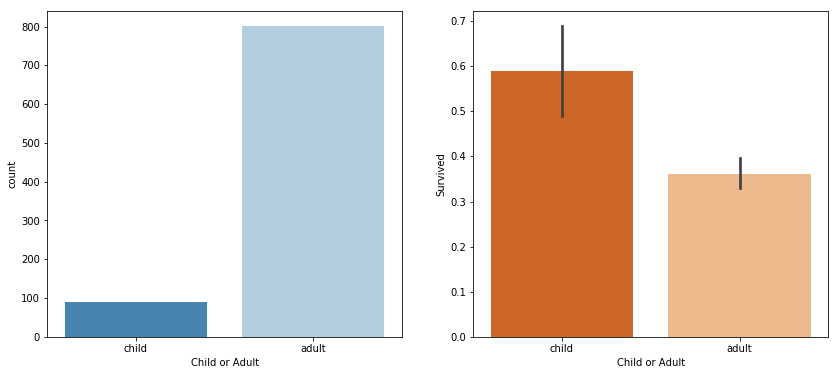

In [42]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'ChildAdult', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Child or Adult')
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survive
sns.barplot('ChildAdult', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Child or Adult')
plt.show()

Children are defined as being under 16 while adults are defined as being 16 or older. Children appear to be more likely to survive the shipwreck than adults. 

### 4b. Resolve Parents/Children on Board and Siblings/Spouses on Board Variables

In [43]:
# Create family size variable
training_data_2['FamilySize'] = training_data_2['SibSp'] + training_data_2['Parch']
testing_data_2['FamilySize'] = testing_data_2['SibSp'] + testing_data_2['Parch']

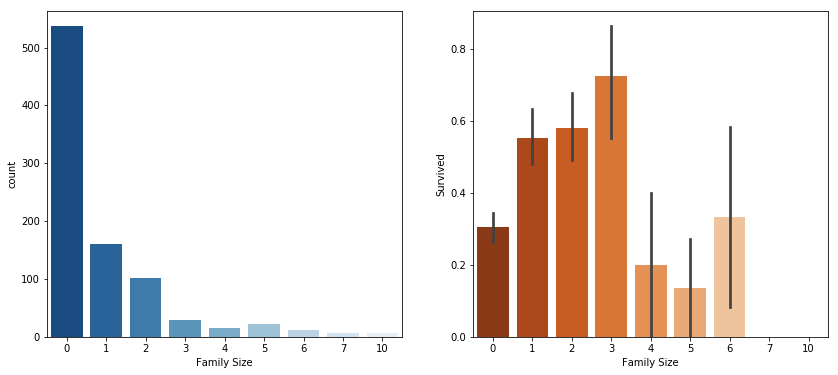

In [44]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of family members on board the Titanic
sns.countplot(x = 'FamilySize', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Family Size')
# Create a plot showing the proportion of passengers with different numbers of family members onboard the Titanic who survived
sns.barplot('FamilySize', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Family Size')
plt.show()

In [45]:
# Create 'WithFamily' variable and define passengers as being with family if family size is greater than 0 
training_data_2['WithFamily'] = np.where((training_data_2['FamilySize'] > 0), 1, 0)
testing_data_2['WithFamily'] = np.where((testing_data_2['FamilySize'] > 0), 1, 0)

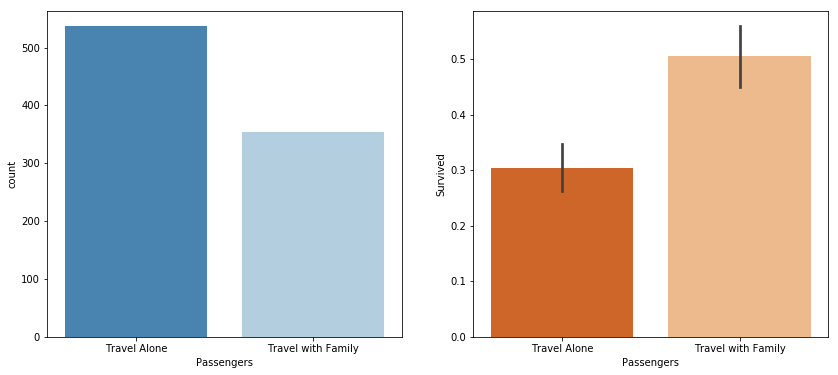

In [46]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the Titanic
sns.countplot(x = 'WithFamily', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
axis1.set_xticklabels(['Travel Alone','Travel with Family'])
# Create a plot showing the proportion of passengers with different numbers of family members onboard the titanic who survived
sns.barplot('WithFamily', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
axis2.set_xticklabels(['Travel Alone', 'Travel with Family'])
plt.show()

'SibSp' and 'Parch' are combined to create a 'FamilySize' variable. Additionally in order to better capture passengers traveling alone versus passengers traveling with family, a 'WithFamily' variable is created.

The meaning behind 'SibSp' and 'Parch' on their own is unclear so the effect is best combined to capture the size of the passenger's family to make the data easier to understand and the results easier to interpret. Additionally, since it appears that passengers traveling along are significantly less likely to survive than passengers traveling with family, the 'WithFamily' variable is created to isolate the effects of passengers traveling alone versus with family.

### 4c. Capture Residual Effects of Traveling with Women and Traveling with Children

In [47]:
# Create variable IsChild that is equal to 1 when the passenger is <16 years old and 0 otherwise
training_data_2['IsChild'] = np.where(training_data_2['ChildAdult'] == 'child', 1 , 0)
testing_data_2['IsChild'] = np.where(testing_data_2['ChildAdult'] == 'child', 1 , 0)
# Create variable IsFemale that is equal to 1 when the passenger is female and 0 otherwise
training_data_2['IsFemale'] = np.where(training_data_2['Sex'] == 'female', 1 , 0)
testing_data_2['IsFemale'] = np.where(testing_data_2['Sex'] == 'female', 1 , 0)

In [48]:
# Create a pivot table that counts the number of women and number of children with each ticket number; This is to be used as a proxy to capture the number of women and children traveling in each group
training_data_4 = training_data_2.copy()
training_data_4.drop(columns = ['Survived'], inplace = True)
combined_data_2 = training_data_4.append(testing_data_2)
ticket_counts_2 = combined_data_2.pivot_table(index = 'Ticket', values = ['Name','IsChild', 'IsFemale'], aggfunc = {'Name':'count', 'IsChild':'sum', 'IsFemale':'sum'})
ticket_counts_2 = ticket_counts_2.rename(columns = {'Name': 'TicketCount', 'IsChild':'NumberOfChildren','IsFemale':'NumberOfFemales'})

In [49]:
# Merge the newly-created pivot tables with the training and testing dataset to access the count of women and children traveling in each group
training_data_2 = training_data_2.merge(ticket_counts_2, left_on='Ticket', right_on = 'Ticket')
testing_data_2 = testing_data_2.merge(ticket_counts_2, left_on='Ticket', right_on = 'Ticket')

In [50]:
# Create dummy variable indicating whether or not a passenger is an adult traveling with a child
training_data_2['TravelWChild'] = np.where((training_data_2['NumberOfChildren']>0) & (training_data_2['ChildAdult'] == 'adult'),1,0)
testing_data_2['TravelWChild'] = np.where((testing_data_2['NumberOfChildren']>0) & (testing_data_2['ChildAdult'] == 'adult'),1,0)
# Create dummy variable indicating whether or not a passenger is a man traveling with a woman
training_data_2['TravelWFemale'] = np.where((training_data_2['NumberOfFemales']>0) & (training_data_2['Sex'] == 'male'),1,0)
testing_data_2['TravelWFemale'] = np.where((testing_data_2['NumberOfFemales']>0) & (testing_data_2['Sex'] == 'male'),1,0)

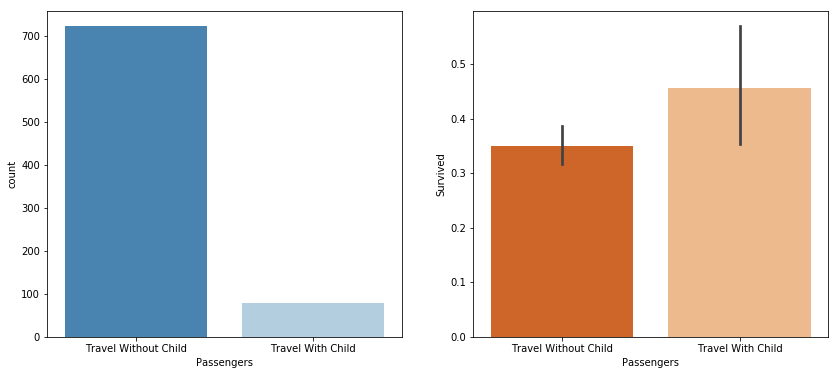

In [51]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations of adults traveling with children and adults traveling without children
sns.countplot(x = 'TravelWChild', data = training_data_2[training_data_2['ChildAdult']=='adult'], palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
axis1.set_xticklabels(['Travel Without Child', 'Travel With Child'])
# Create a plot showing the proportion of adults traveling with children and adults traveling without children who survived
sns.barplot('TravelWChild', 'Survived', data = training_data_2[training_data_2['ChildAdult']=='adult'] , palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
axis2.set_xticklabels(['Travel Without Child', 'Travel With Child'])
plt.show()

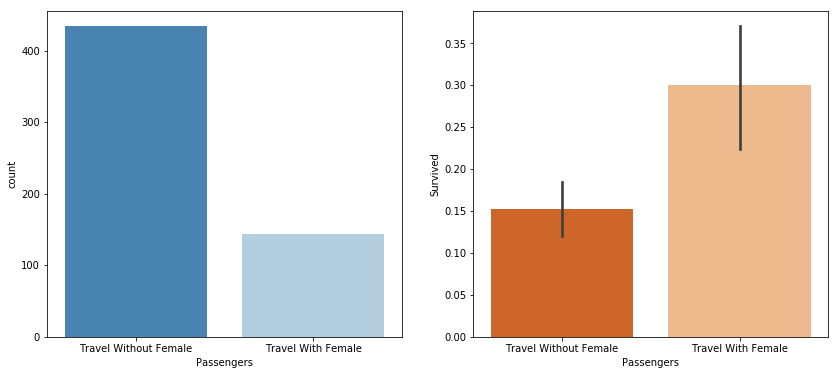

In [52]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations of men traveling with a female and men traveling without a female
sns.countplot(x = 'TravelWFemale', data = training_data_2[training_data_2['Sex']=='male'], palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
axis1.set_xticklabels(['Travel Without Female', 'Travel With Female'])
# Create a plot showing the proportion of men traveling with women and men traveling without women who survive
sns.barplot('TravelWFemale', 'Survived', data = training_data_2[training_data_2['Sex']=='male'], palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
axis2.set_xticklabels(['Travel Without Female', 'Travel With Female'])
plt.show()

It appears that women and children are more likely to survive the shipwreck than other passengers. It is also possible that women and children have a residual impact on the survivorship for the other passengers in their parties. For example, if a child were to board a lifeboard, perhaps the Titanic crew members require a parent/guardian to chaperone the child on the lifeboat. So adults traveling with children may have higher odds of surviving the shipwreck.

The fields 'TravelWFemale' and 'TravelWChild' are created to capture this residual effect. 'TravelWFemale' captures men who share ticket numbers at least one woman. 'TravelWChild' captures adults who share ticket numbers with at least one child. 

Preliminary investigation shows that ~10-15% of adults travel with at least one child and ~25% of men travel with at least one woman. Adults traveling with at least one child have higher survivorship rates than adults traveling without a child and men traveling with at least one woman have higher survivorship rates than men traveling without any women. 

### 4d. Turning 'Fare' feature into 'FarePerPassenger'

In [53]:
# Calculate 'FarePerPassenger' as 'Fare' / 'TicketCount' in order to capture the fare related to each individual observation
training_data_2['FarePerPassenger'] = training_data_2['Fare'] / training_data_2['TicketCount']
testing_data_2['FarePerPassenger'] = testing_data_2['Fare'] / testing_data_2['TicketCount']

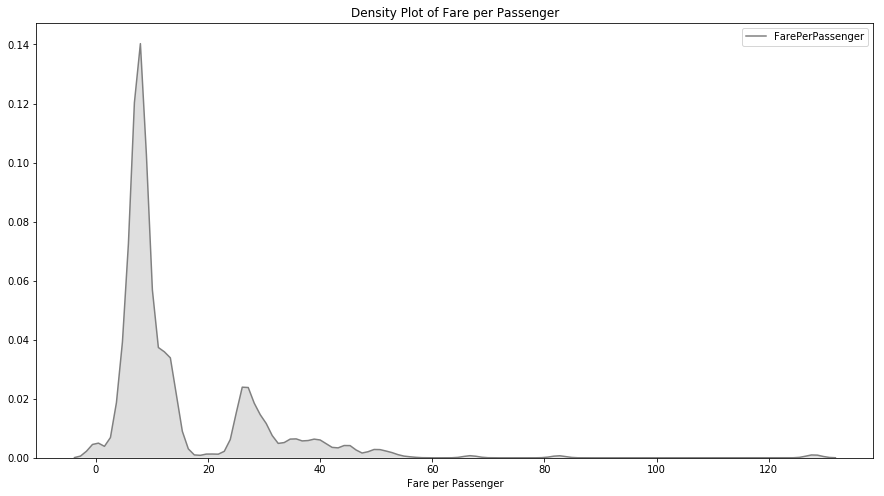

In [54]:
# Plot the density plot of fare per passenger
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'], color='grey', shade=True)
plt.title('Density Plot of Fare per Passenger')
ax1.set(xlabel = 'Fare per Passenger')
plt.show()

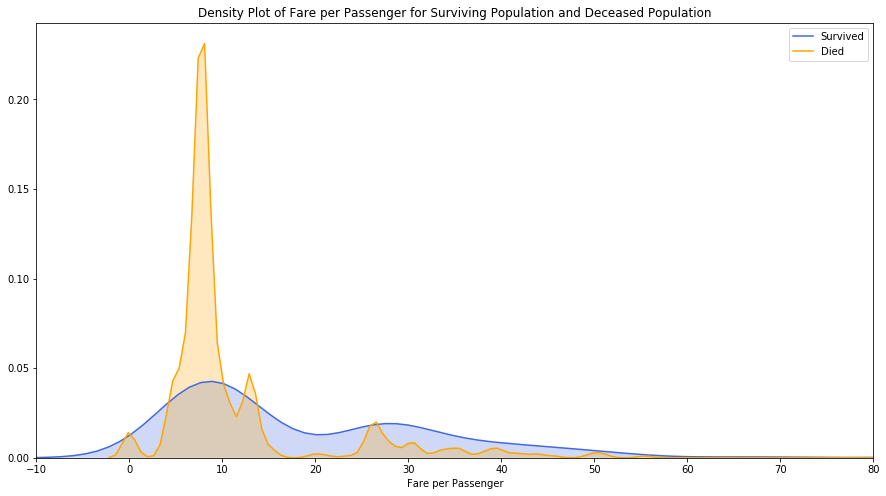

In [55]:
# Plot density plots of fares paid per passenger for passengers who survive relative to passengers who die 
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare per Passenger for Surviving Population and Deceased Population')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

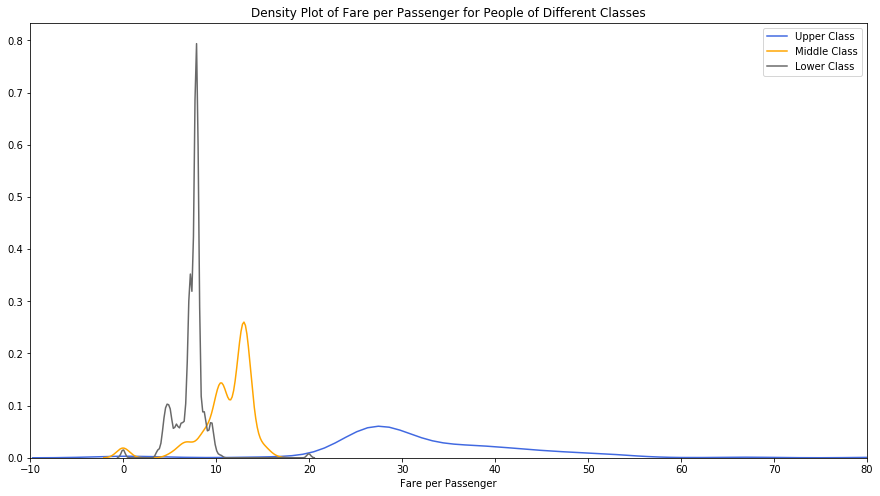

In [56]:
# Plot density plots of fares paid per passenger for passengers for upper, middle, and lower class passengers
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 1)], color = 'royalblue')
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 2)], color = 'orange')
ax3 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 3)], color = 'dimgray')
plt.legend(['Upper Class', 'Middle Class', 'Lower Class'])
plt.title('Density Plot of Fare per Passenger for People of Different Classes')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

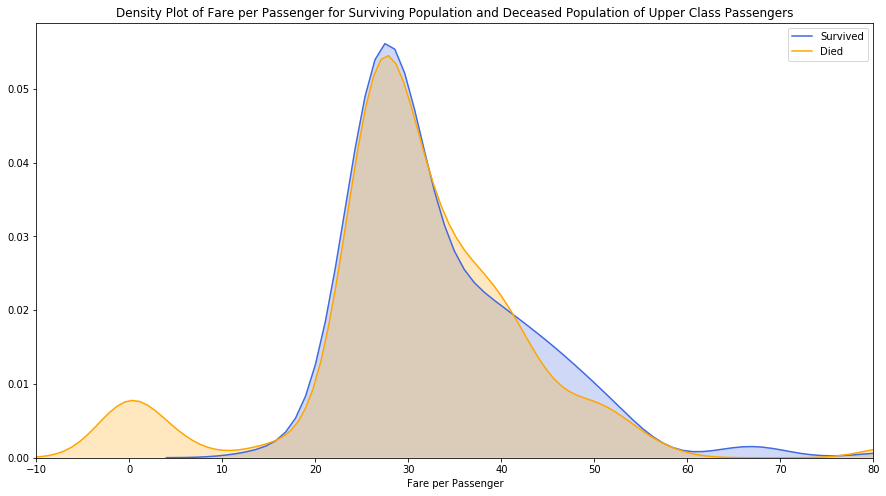

In [57]:
# Plot density plots of fares paid per passenger for passengers who survive relative to passengers who die for upper class passengers only 
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 1)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 1)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare per Passenger for Surviving Population and Deceased Population of Upper Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

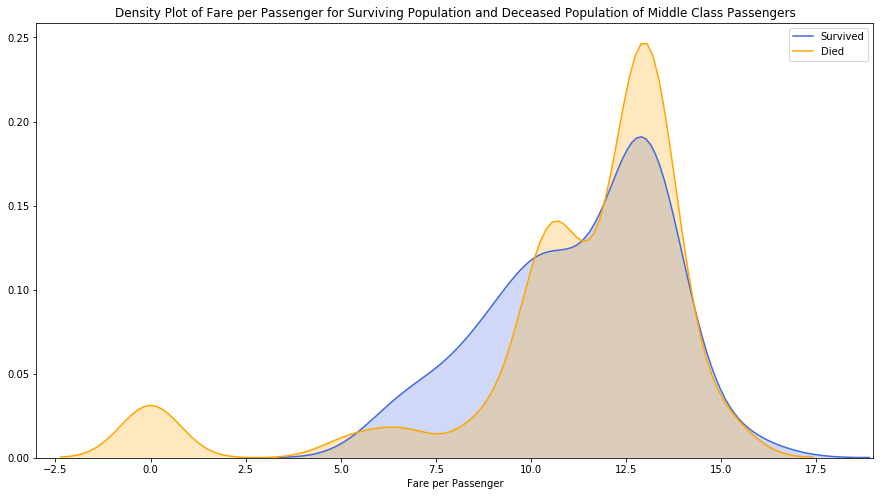

In [58]:
# Plot density plots of fares paid per passenger for passengers who survive relative to passengers who die for middle class passengers only
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 2)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 2)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare per Passenger for Surviving Population and Deceased Population of Middle Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-3,19)
plt.show()

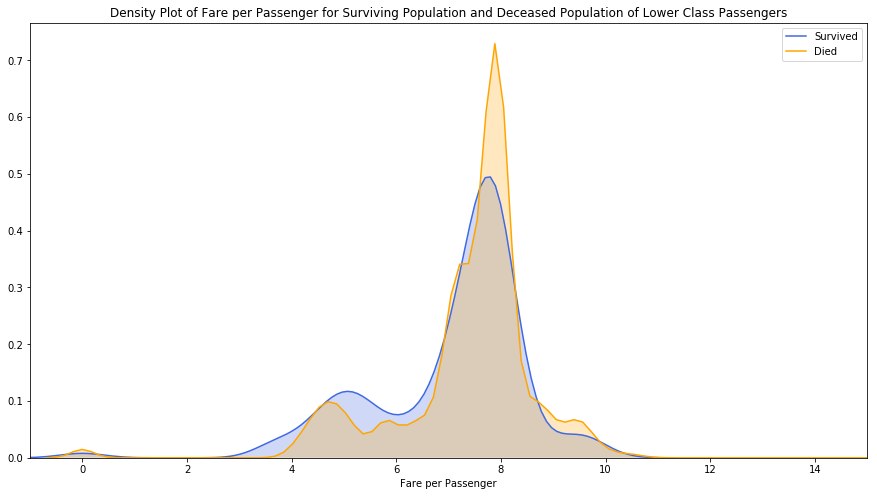

In [59]:
# Plot density plots of fares paid per passenger for passengers who survive relative to passengers who die for lower class passengers only
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 3)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 3)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare per Passenger for Surviving Population and Deceased Population of Lower Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-1,15)
plt.show()

The 'Fare' field captures the fare paid for each ticket. Since a ticket number can apply to an entire group of passengers, the fare paid applies to multiple people in many cases. In order to better capture the effect of fare paid at the passenger level, a 'FarePerPassenger' field is created as 'Fare' divided by the number of passengers corresponding to the applicable ticket number.

It appears that on a whole the distribution of fares paid per passenger is overall different for passengers who survive the shipwreck relative to passengers who do not survive the shipreck. However, when distributions are cut by passenger class, the differences in distributions of fares paid by passengers who survive and do not survive the shipwreck is less clear. This indicates that while fare paid per passenger could impact survivorship, fare paid per passenger may also be closely related to passenger class.

# 5. Logistic Regression

### 5a. Background

Logistic regression models the probability that the binary dependent variable Y falls into one of two categories. Logistic regression describes the relationship between the binary dependent variable and one or more independent variables. The model is is fit using maximum likelihood.

### 5b. Prepare variables for logistic regression

In [60]:
# Since data has been cleaned and new features produces, create a new dataframe for the cleaned data
training_data_cleaned = training_data_2.copy()
testing_data_cleaned = testing_data_2.copy()

In [61]:
# Create a dataframe for the data used in training the logistic regression model
log_res_training = training_data_cleaned.copy()

In [62]:
# Drop variables that are not being used
log_res_training.drop(columns = ['Cabin','Age','SibSp', 'Parch', 'FamilySize','Name', 'Ticket','Sex', 'ChildAdult','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare'], inplace = True)

In [63]:
# Create binary variables for all categorical variables and drop the first category to avoid perfect multicollinearity
log_res_training = pd.get_dummies(log_res_training, columns = ['Embarked'], drop_first = True)

In [64]:
# Apply standard scaler to 'Fare' column
fare_per_passenger = log_res_training[['FarePerPassenger']].values
fare_per_passenger = StandardScaler().fit_transform(fare_per_passenger)
log_res_training['FarePerPassenger'] = fare_per_passenger

In [65]:
# Take a look at the final dataset
log_res_training.head()

,Survived,Pclass,WithFamily,IsChild,IsFemale,TravelWChild,TravelWFemale,FarePerPassenger,Embarked_Q,Embarked_S
0,0,3,1,0,0,0,0,-0.538133,0,1
1,1,1,1,0,1,0,0,1.554499,0,0
2,1,3,0,0,1,0,0,-0.488382,0,1
3,1,1,1,0,1,0,0,0.884390,0,1
4,0,1,1,0,0,0,1,0.884390,0,1


In [66]:
# Define the dependent and independent variables
y_logistic = log_res_training.iloc[:,0].values
X_logistic = log_res_training.iloc[:,1:].values

In order to prepare the dataset for logistic regression, it is important to change the nominal variables ('Sex', 'Embarked', and 'ChildAdult') into separate binary variables for each of the classifications. For example, 'Embarked' has a separate binary variable for whether or not the passenger embarked from Cherbourg, Queenstown, or Southhampton. For logistic regression, it is critical to remove one of the binary variables from each category in order to prevent perfect multicollinearity across the independent variables. For example, if only binary variables indicating if the passenger embarked from 'Queenstown' and 'Southhampton' are included, it is not necessary to include a binary variable indicating if the passenger embarked from 'Cherbourg' because if both the Queenstown and Southhampton indicate a 0 value, then by default the passenger must have embarked from 'Cherbourg', which is captured by the intercept term.

Coefficients in logistic regression are determined by minimizing the cost function (log los) using gradient descent. As a result, it is important to apply feature scaling to variables with wide ranges to ensure that the conversion to the global minimum (the gradient descent process that happens to establish the coefficients) happens more quickly.

'Pclass' is a variable that indicates whether a passenger is upper class, middle class, or lower class. The variable is originally indicated as 1 (upper), 2 (middle), or 3 (lower). Since the range of values for this variable is relatively narrow and applying feaure scaling to this variable would mean losing interpretability of this variable, feature scaling is not applied to 'Pclass' in this model.

'FarePerPassenger' is a variable that indicates the price the passenger paid for her/his ticket. This variable has a wide range so this variable needs to be scaled down to make establishing the coefficients more efficient. The variable is standardized based on the normal distrbution so that the mean of the variable is ~0 and the standard deviation of the variable is ~1.

### 5c. Run first logistic regression

In [67]:
# Fit a logistic model to the data
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.451050
         Iterations 6


In [68]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3227
Time:                        23:58:39   Log-Likelihood:                -401.89
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 8.558e-78
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7009      0.095     -7.399      0.000      -0.887      -0.515
x2            -0.3972      0.258     -1.538      0.124      -0.903       0.109
x3             1.1010      0.325      3.389      0.001       0.464       1.738
x4             2.8758      0.244     11.776      0.000       2.397       3.354
x5             0.0019      0.330      0.006      0.995      -0.645       0.649
x6             0.6428      0.325      1.979      0.048       0.006       1.279
x7             0.2640      0.110      2.397      0.017       0.048       0.480
x8             0.0861      0.380      0.227      0.821      -0.659       0.831
x9            -0.1996      0.212     -0.940      0.347      -0.616       0.217
==============================================================================
"""

The initial output reveals several independent variables with p-value > 0.05. The p-value for regression coefficients quantifies how much confidence there is that the independent variable impacts the dependent variable. The smaller the p value, the stronger the evidence that there is a relationship between the independent and dependent variable. A p-value threshold of 0.05 is used in this analysis. 

There is not a good reason to keep insignificant variables in the model so a backward elimination approach is used to ensure that all variables used in the logistic regression have statistically significant relationships with the dependent variable. In the backward elimination approach, the model is run and the p-value of each independent variable is observed. Then, the independent variable with the largest p-value greater than 0.05 is removed from the model. This methodology is repeated until all remaining independent variables have p-values less than 0.05.

### 5d. Run subsequent logistic regression models using a backward elimination approach

In [69]:
# The 'TravelWChild' variable (Binary variable indicating whether or not the individual traveled with a child) has a high p-value revealing that the variable is not statistically significant in this model. Remove the 'TravelWChild' variable
X_logistic = np.delete(X_logistic,4, axis = 1)

In [70]:
# Fit a logistic model to the data (with the 'TravelWChild' variable removed) 
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.451050
         Iterations 6


In [71]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3227
Time:                        23:58:39   Log-Likelihood:                -401.89
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.114e-78
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7009      0.095     -7.403      0.000      -0.886      -0.515
x2            -0.3967      0.246     -1.611      0.107      -0.879       0.086
x3             1.1004      0.307      3.590      0.000       0.500       1.701
x4             2.8760      0.242     11.863      0.000       2.401       3.351
x5             0.6429      0.325      1.981      0.048       0.007       1.279
x6             0.2638      0.107      2.460      0.014       0.054       0.474
x7             0.0858      0.377      0.228      0.820      -0.653       0.825
x8            -0.1996      0.212     -0.940      0.347      -0.616       0.216
==============================================================================
"""

In [72]:
# The 'Embarked_Q' variable (Binary variable indicating whether or not the individual embarked the Titanic from the Queenstown port) has a high p-value revealing that the variable is not statistically significant in this model. Remove the 'Embarked_Q' variable
X_logistic = np.delete(X_logistic,6, axis = 1)

In [73]:
# Fit a logistic model to the data (with the 'TravelWChild' and 'Embarked_Q' variables removed)
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.451079
         Iterations 6


In [74]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3226
Time:                        23:58:39   Log-Likelihood:                -401.91
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.369e-79
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6896      0.081     -8.558      0.000      -0.848      -0.532
x2            -0.4052      0.244     -1.664      0.096      -0.883       0.072
x3             1.0908      0.304      3.591      0.000       0.495       1.686
x4             2.8858      0.239     12.084      0.000       2.418       3.354
x5             0.6553      0.320      2.047      0.041       0.028       1.283
x6             0.2644      0.107      2.461      0.014       0.054       0.475
x7            -0.2257      0.179     -1.264      0.206      -0.576       0.124
==============================================================================
"""

In [75]:
# The 'Embarked_S' variable (Binary variable indicating whether or not the individual embarked the Titanic from the Southampton port) has a high p-value revealing that the variable is not statistically significant in this model. Remove the 'Embarked_S' variable
X_logistic = np.delete(X_logistic,6, axis = 1)

In [76]:
# Fit a logistic model to the data (with the 'TravelWChild', 'Embarked_Q', and 'Embarked_S' variables removed)
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.451974
         Iterations 6


In [77]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3213
Time:                        23:58:39   Log-Likelihood:                -402.71
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.275e-80
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7559      0.062    -12.197      0.000      -0.877      -0.634
x2            -0.4476      0.242     -1.850      0.064      -0.922       0.027
x3             1.1234      0.302      3.716      0.000       0.531       1.716
x4             2.9096      0.239     12.153      0.000       2.440       3.379
x5             0.6723      0.320      2.099      0.036       0.045       1.300
x6             0.2396      0.103      2.321      0.020       0.037       0.442
==============================================================================
"""

In [78]:
# The 'WithFamily' variable (binary variable indicating whether or not a passenger is traveling with family) has a high p-value revealing that the variable is not statistically significant in this model. Removing the 'WithFamily' variable
X_logistic = np.delete(X_logistic,1, axis = 1)

In [79]:
# Fit a logistic model to the data (with the 'TravelWChild', 'Embarked_Q', 'Embarked_S', and 'WithFamily' variables removed)
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.453943
         Iterations 6


In [80]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3183
Time:                        23:58:40   Log-Likelihood:                -404.46
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.801e-80
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7658      0.062    -12.441      0.000      -0.886      -0.645
x2             1.0061      0.295      3.408      0.001       0.427       1.585
x3             2.6836      0.201     13.352      0.000       2.290       3.077
x4             0.3199      0.256      1.250      0.211      -0.182       0.821
x5             0.2273      0.102      2.238      0.025       0.028       0.426
==============================================================================
"""

In [81]:
# The 'TravelWFemale' variable (variable indicating whether a male passenger is traveling with a female) has a high p-value revealing that the variable is not statistically significant in this model. Removing the 'TravelWFemale' variable
X_logistic = np.delete(X_logistic,3, axis = 1)

In [82]:
# Fit a logistic model to the data (with the with the 'TravelWChild', 'Embarked_Q', 'Embarked_S', 'WithFamily', and 'TravelWFemale' variables removed)
logistic_regression_classifier = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.454805
         Iterations 6


In [83]:
# Show coefficients of the logistic regression
logistic_regression_classifier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                  0.3170
Time:                        23:58:40   Log-Likelihood:                -405.23
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.174e-81
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7298      0.053    -13.731      0.000      -0.834      -0.626
x2             1.1313      0.284      3.990      0.000       0.576       1.687
x3             2.5879      0.184     14.075      0.000       2.227       2.948
x4             0.2806      0.094      3.000      0.003       0.097       0.464
==============================================================================
"""

In [84]:
# Fit the final logistic regression classifier
logistic_regression_classifier = LogisticRegression(random_state = 0)
logistic_regression_classifier.fit(X_logistic, y_logistic)

LogisticRegression(random_state=0)

The following variables all have p-values less than 0.05 and thus remain in the logistic regression model:
* 'Pclass': An ordinal variable indicating someone's passenger class using a rating of 1 (upper class), 2 (middle class), or 3 (lower class)
* 'FarePerPassenger': The price that the passenger paid to board the ship (note that this variable was standardized to have a mean of 0 and a standard deviation of ~1)
* 'isChild': A binary variable indicating whether or not the passenger is a child (defined as younger than 16 in this analysis). 1 indicates that the passenger is a child. 0 indicates that the passenger is an adult.
* 'isFemale': A binary variable indicating whether or not the passenger is female. 1 indicates the passenger is female. 0 indicates the passenger is male

# 6. Decision Tree

### 6a. Background

Important Terminology:
* Parent Node: A node that is further divided into sub-nodes.
* Child Node: A node that results from the division of a parent node.
* Root Node: The very beginning of a decision tree that represents the entire population or sample. The root node is divided into two or more sets. The root node only has arrows pointing away from it meaning that it does not have a parent.
* Internal Node / Node: A node within a decision tree that is beyond the root node and before the leaf nodes. Internal nodes have arrows pointing towards them and arrows pointing away from them. Internal nodes carry at least one child. 
* Leaf Node / Terminal Node: Nodes that do not split.  
* Branches: Segments of the decision tree that connect the nodes.
* Splitting: Process of dividing a node into two or more sub-nodes.
* Pruning: Removing sub-nodes of a decision model. The opposite process of splitting.

Decision trees involve stratifying or segmenting the predictor space into a number of simple regions. A decision tree begins with all data in the population / sample at the root node. All data in the population/sample is split based on criteria (e.g. whether the passenger on the Titanic is male or female). Following the initial split, the algorithm performs subsequent splits (called internal nodes) until the algorithm arrives at points (at leaf nodes) where the algorithm cannot perform additional splits. When the algorithm arrives at a leaf node, the algorithm classifies the observation as the mode classification of the training observations that fall in the region (so if 9 total passengers in the training dataset fall into a leaf node and 5 of whom survive the shipwreck while 4 of whom do not survive the shipwreck then the algorithm classifies observations that fall into the leaf node as 'survived').

The decision tree algorithm itself creates splits based on the purity of the nodes directly after the split (most commonly using Gini index or entropy). Purity refers to the homogeneity of split observations based on the classification of interest. A node is 100% pure when all of its data belongs to a single class (so if a node contains 100% surviving passengers or 100% deceased passengers, the node is pure). A node becomes less pure when it contains observations corresponding to multiple classifications. A Gini Index of 0 means that a node is pure and a Gini Index of 1 means the elements within the node are randomly distributed across various classes. At each split, the algorithm compares the purity of the resulting nodes at all possible splits (so all possible independent variables to be used at the split and all possible values within each independent variable to be used at the split). The split that results in nodes that are overall most pure (using weighted average Gini index or entropy) is selected and used in the model. This process repeats for subsequent decision tree splits until the algorithm reaches a stopping point.

### 6b. Prepare variables for decision tree

In [85]:
# Make a copy of the cleaned training data to avoid errors
dec_tree_training = training_data_cleaned.copy()

In [86]:
# Drop variables not being used
dec_tree_training.drop(columns = ['Cabin','SibSp', 'Parch','Name', 'Ticket','Sex', 'ChildAdult','IsChild','WithFamily','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare'], inplace = True)

In [87]:
# Create dummy variables for nominal categorical variables
dec_tree_training = pd.get_dummies(dec_tree_training, columns = ['Embarked'])

In [88]:
# Look at the dataset
dec_tree_training.head()

,Survived,Pclass,Age,FamilySize,IsFemale,TravelWChild,TravelWFemale,FarePerPassenger,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,0,0,7.25000,0,0,1
1,1,1,38.0,1,1,0,0,35.64165,1,0,0
2,1,3,26.0,0,1,0,0,7.92500,0,0,1
3,1,1,35.0,1,1,0,0,26.55000,0,0,1
4,0,1,37.0,1,0,0,1,26.55000,0,0,1


In [89]:
# Define x and y variables for the decision tree
y_tree = dec_tree_training.iloc[:,0].values
X_tree = dec_tree_training.iloc[:,1:].values

Note that when dummy variables are created for the nominal categorical variables, a column is not deleted for the 'Embarked' data. Multicollinearity is no longer a concern for the Decision Tree Model because decision trees are not linear models. Additionally, scaling the fare paid per passenger is not necessary for decision trees.

### 6c. Run initial decision tree

In [90]:
# Create a decision tree to the data without passing any parameters
tree_1 = DecisionTreeClassifier()
tree_1 = tree_1.fit(X_tree, y_tree)

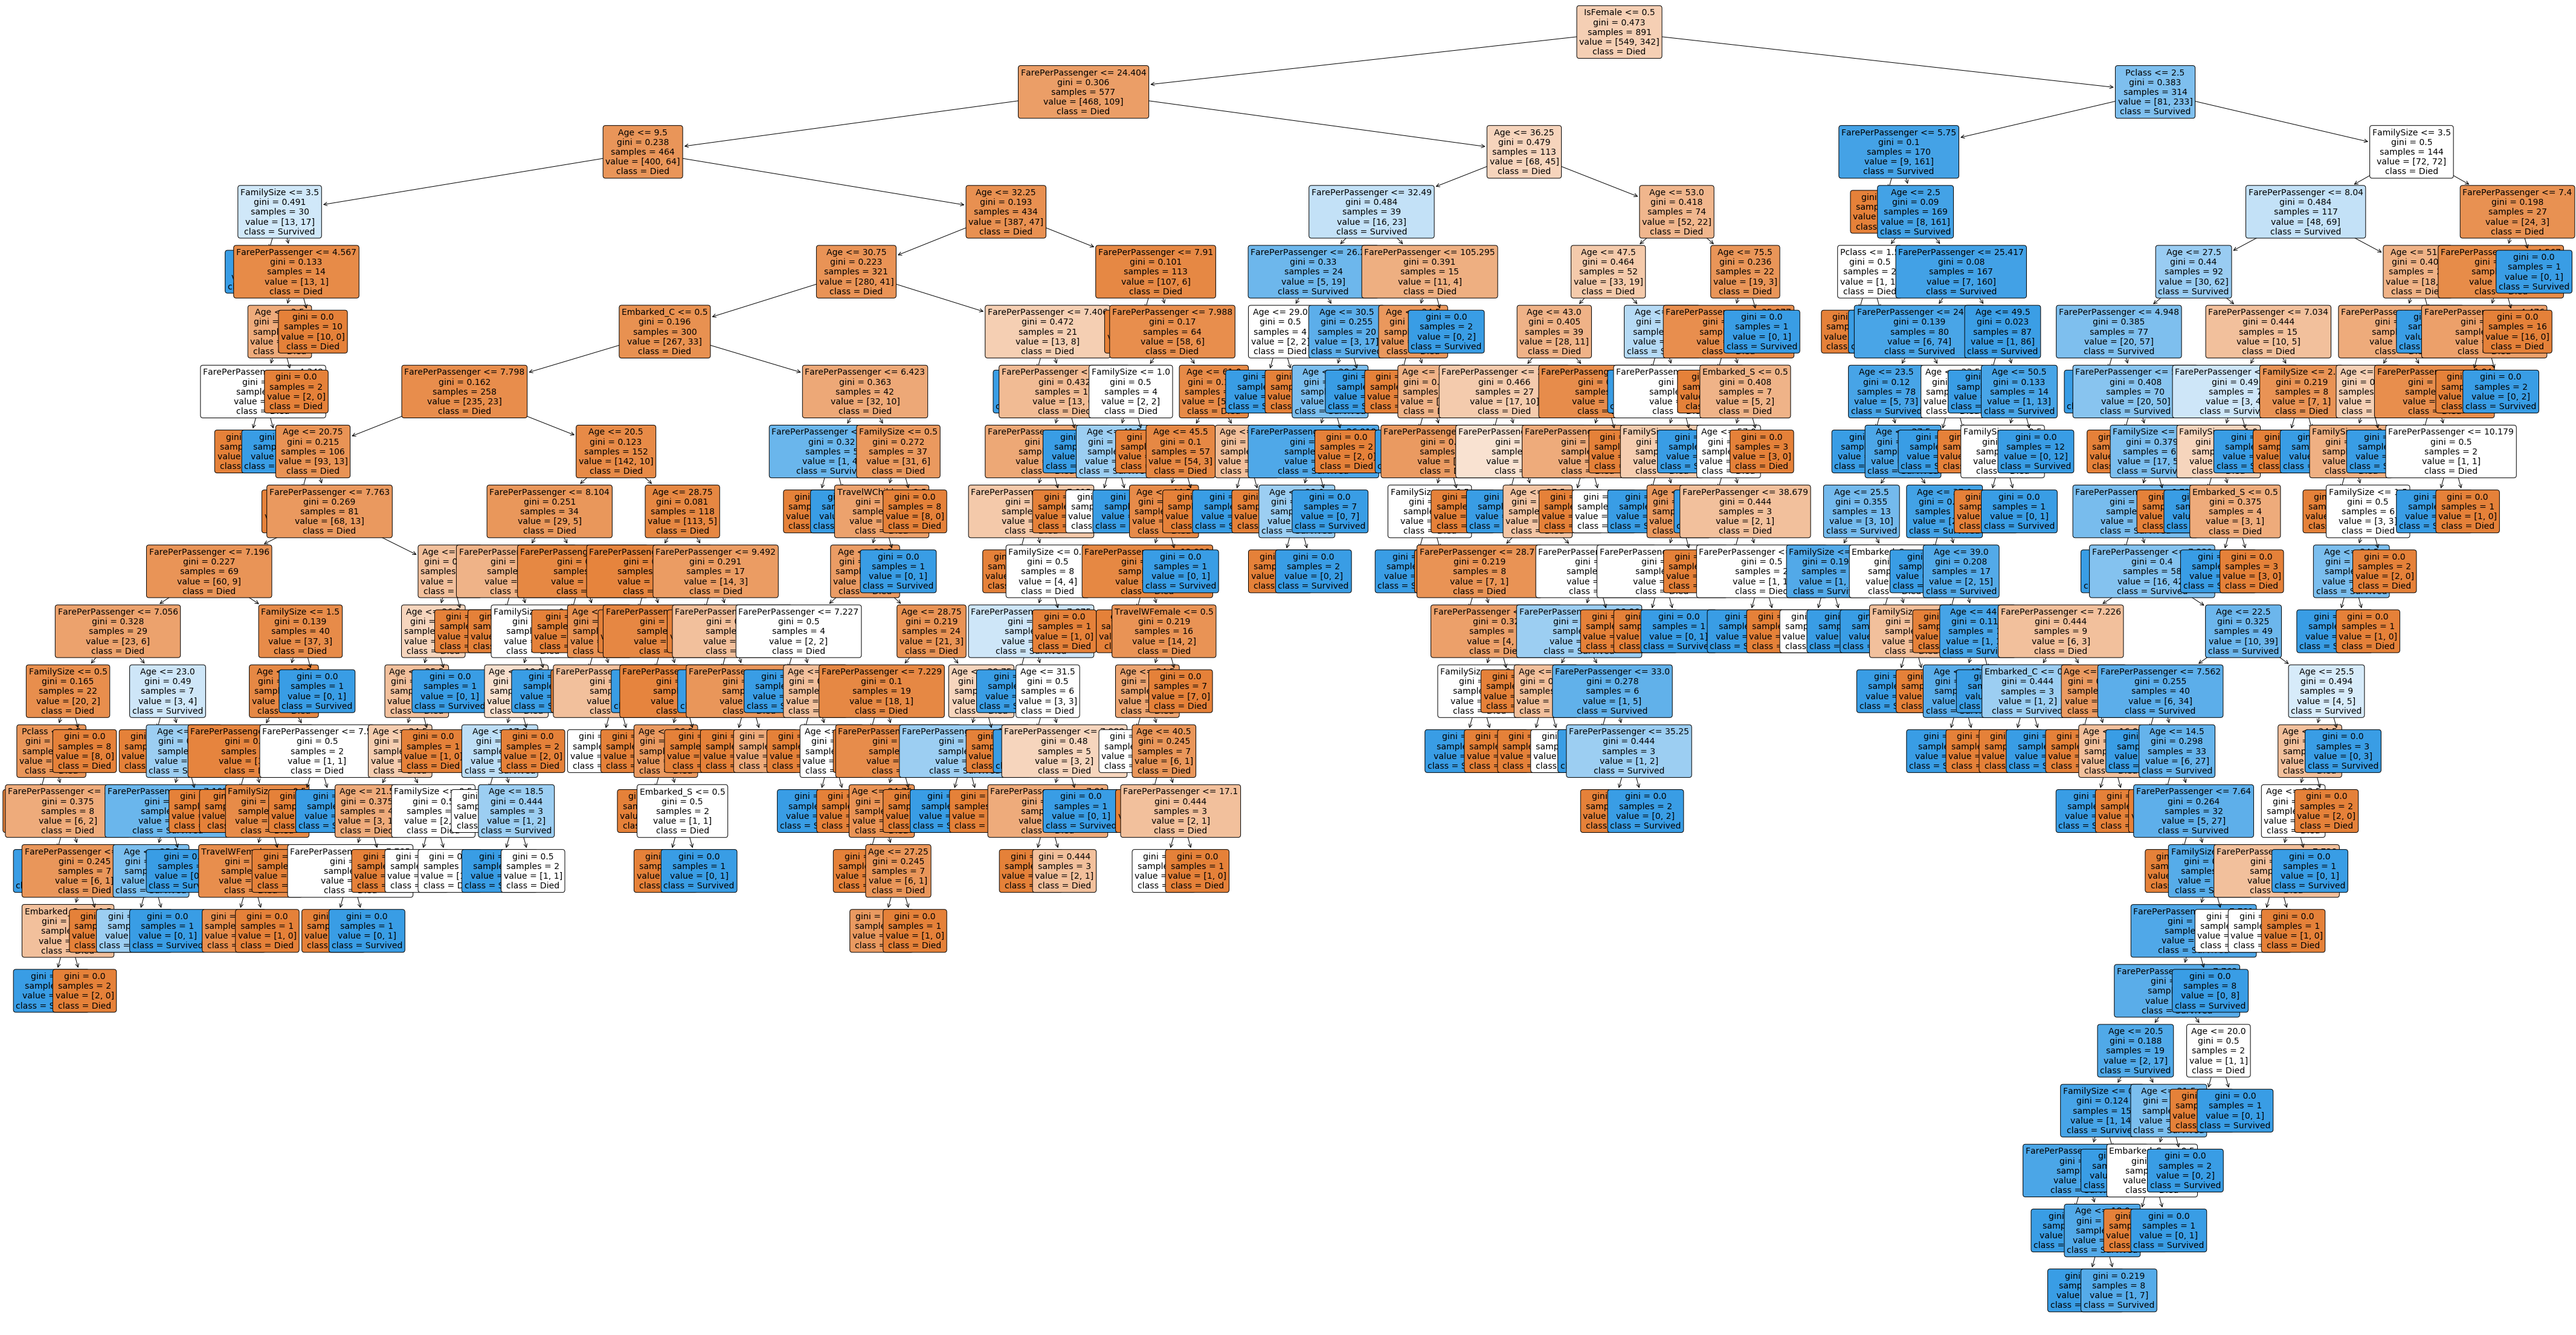

In [91]:
# Show chart of this initial decision tree
plt.figure(figsize=(75,40))
tree_1_image = plot_tree(tree_1, 
              feature_names=dec_tree_training.iloc[:,1:].columns, 
              class_names={0:'Died',1:'Survived'},
              filled=True, 
              rounded=True, 
              fontsize=14)

The initial tree is very deep and is very difficult to explain. When no parameters are set, the decision tree grows until either all leaves are pure or until all leaves contain less than the min_samples_split samples (default = 2). Since the default min_samples_leaf value is 1, the algorithm is able to create splits until there is only one observation left in a leaf node. 

Given the size and lack of interpretability of this initial decision tree, it is likely that this decision tree is overfitting the data. Overfitting occurs when a function is too closely fit to a limited set of data points. As a result, while overfit models tend to perform well on training data, but poorly on new observations (testing data).

In order to prevent overfitting, the model needs to be optimized. See below for definitions of the parameters that are optimized in section 6d:
* max_depth: The default is set to 'None'. This defines the maximum depth of a tree. If None, the nodes are expanded until all leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting and a lower value causes underfitting. If not set to a limit, the decision tree will split until all leaves are pure or until all leaves contain less than the min_samples_split (default = 2) samples
* min_samples_leaf: The default is set to one. This defines the minimum number of samples required to be at a leaf node. 
* min_samples_split: The default is set to two. This defines the minimum number of samples required to split an internal node. 

### 6d. Create optimized decision tree

In [92]:
# Define a list of max_depths, min_samples_leaves, and min_samples_splits
max_depths = list(range(1,41))
min_samples_leaves = list(range(1,41))
# min_samples_splits = list(range(1,41))

In [93]:
# Pass the parameters into GridSearchCV
grid_decision_tree = GridSearchCV(DecisionTreeClassifier(),{'max_depth': max_depths, 'min_samples_leaf': min_samples_leaves}, cv = 5,scoring = 'roc_auc', n_jobs = -1)

In [94]:
# Use GridSearchCV to figure out the best possible parameters to pass
grid_decision_tree.fit(X_tree, y_tree)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='roc_auc')

In [95]:
# Fit the newly optimized decision tree
tree_2 = DecisionTreeClassifier(max_depth = grid_decision_tree.best_params_['max_depth'], min_samples_leaf = grid_decision_tree.best_params_['min_samples_leaf'])
tree_2 = tree_2.fit(X_tree, y_tree)

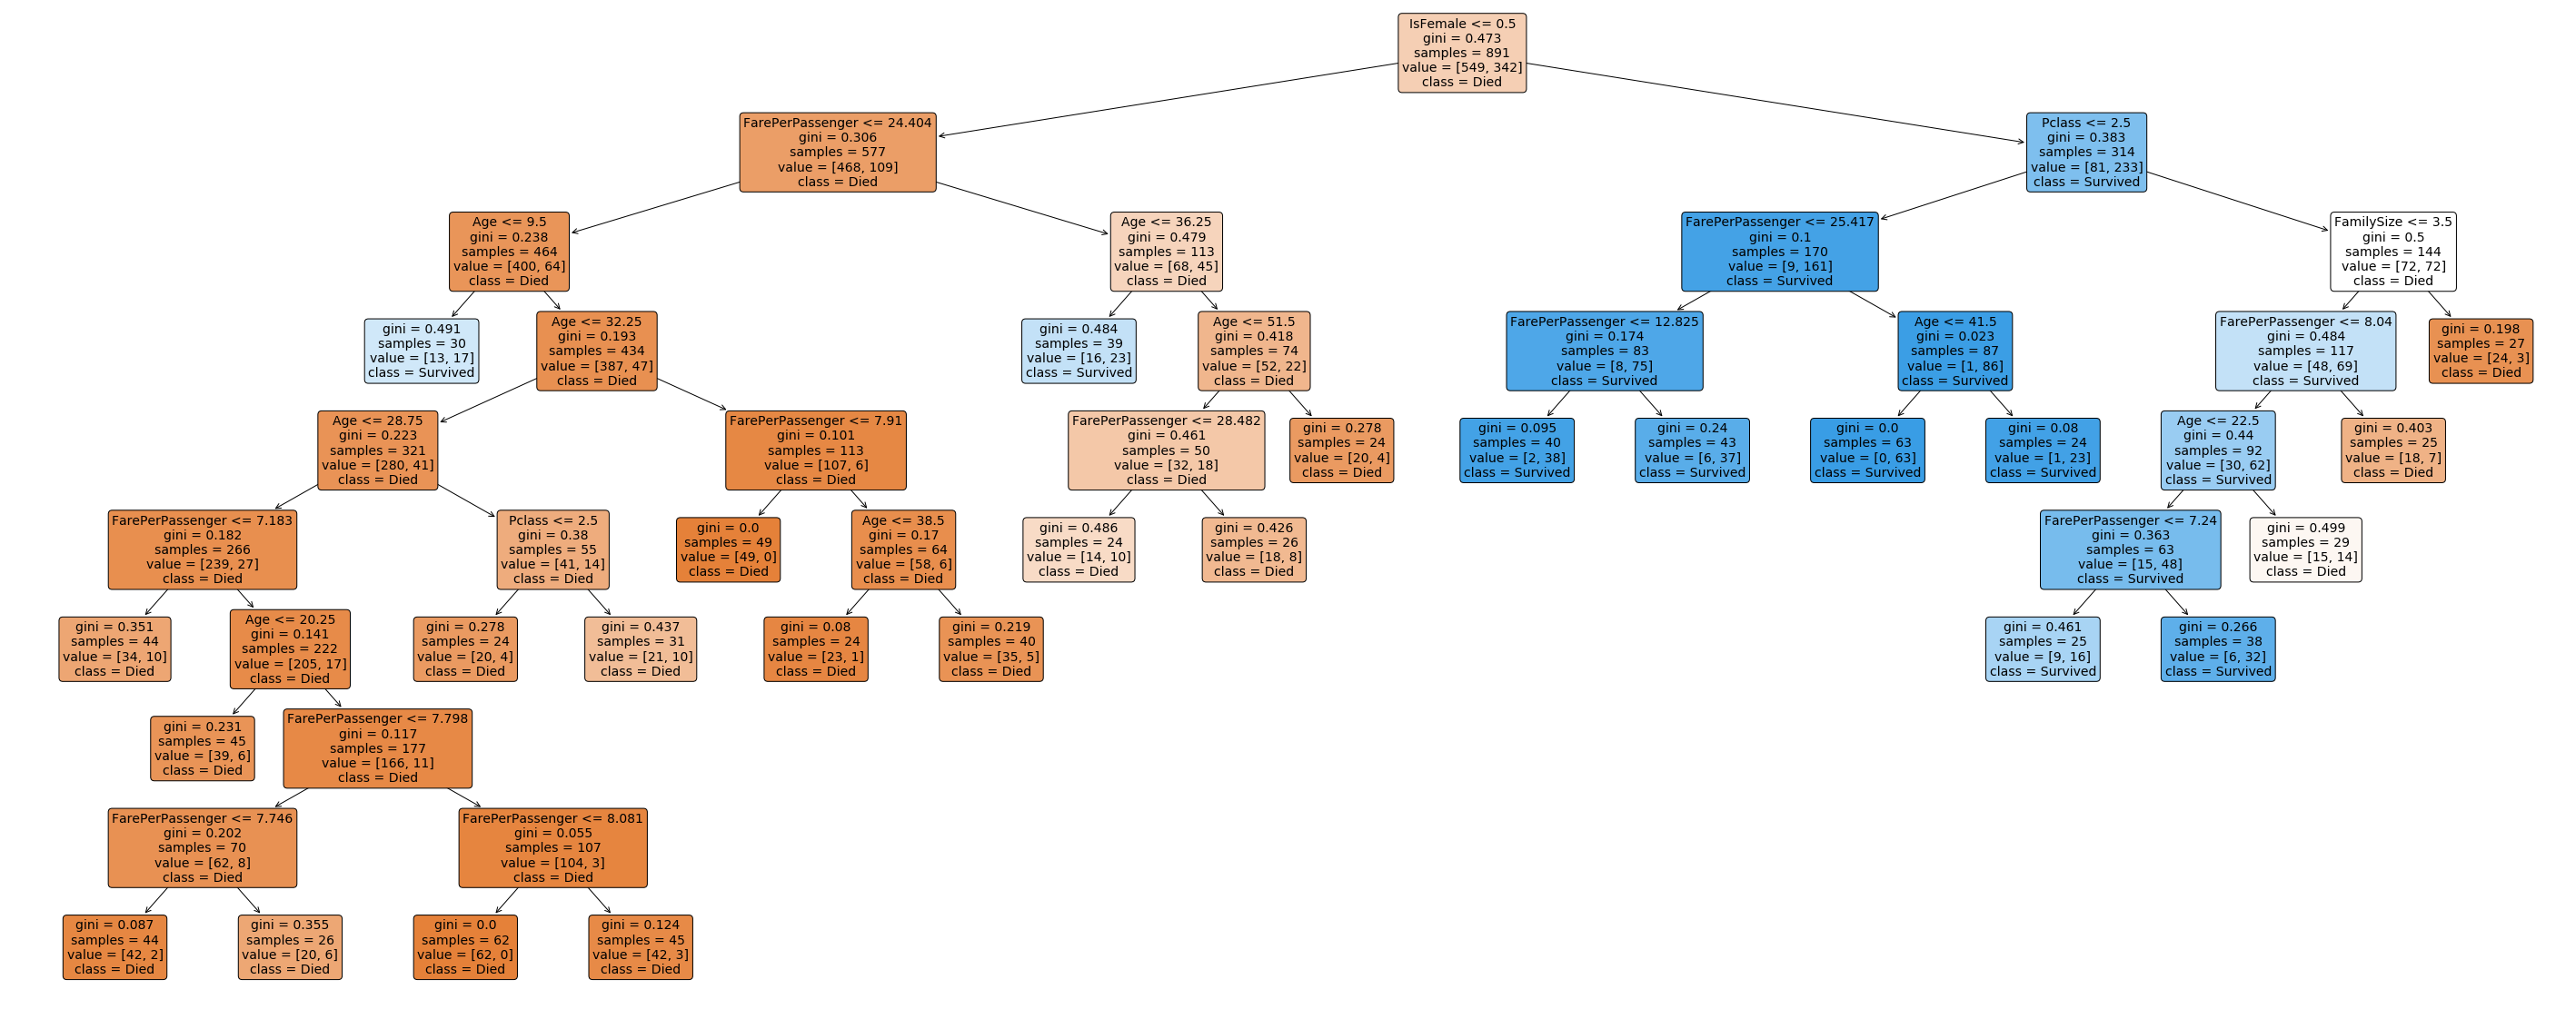

In [96]:
# Display the newly optimized decision tree
plt.figure(figsize=(50,20))
tree_2_image = plot_tree(tree_2, 
              feature_names=dec_tree_training.iloc[:,1:].columns, 
              class_names={0:'Died',1:'Survived'},
              filled=True, 
              rounded=True, 
              fontsize=14)

In the above example, GridSearchCV is used to optimize the decision tree. GridSearchCV accepts a set of parameters, tries all possible combinations of those parameters, and keeps track of the resulting cross validation scores for all combinations of parameters. Max_depth, min_samples_leaf, and min_samples_split from 1 to 40 are all attempted at all combinations and the best performing combination of all parameters is selected.

Cross validation partitions the data into K bins of equal size. The algorithm uses this data to run K different learning experiments. Each learning experiement uses a different partition as the test set and the remaining K-1 partitions as the training set. After the algorithm runs the K experiments, the resulting performances from the K experiments are averaged to get the model's overall performance. In the case of the above example, cross validation is run using 5 partitions meaning that 20% of the data is tested in each of the 5 experiements. 

In order to choose the optimal parameters of the model, 'ROC_AUC' is used to assess model performance. 

An ROC graph shows the true positive rate (sensitivity or (TP)/(TP+FN)) on the y-axis and the false positive rate (1 - specificity or (FP)/(FP+TN)) on the x axis. Calculating sensitivity and 1-specificity for all possible thresholds for a given model creates the points for the ROC curve. A diagonal line marking instances in which the true positive rate = false postive rate provides a contrast to the ROC curve. The diagonal line marks instances in which the proportion of correctly classified positive samples is the same proportion of incorrectly classified negative samples. 

AUC measures the area under the ROC curve or the percentage of the overall graph beneath the ROC curve. Higher AUC scores indicate better performing models while lower AUC scores indicate poorer model performance. An AUC score of 0.5 means that AUC is equal to that of the diagonal line meaning that the model has no capacity to distinguish between the positive class and the negative class. An AUC score of 1.0 means the classifier is perfect with both high sensitivity and high specificity.

In the above diagram, there are some splits that yield the same predicted value in all divisions of a singular split. This is because splits are created to maximize node purity. Instances in which there is a final split that yields two leaf notes with identical predicted classifications are the result of one leaf node having more node purity than the other.

While Decision Trees are easy to interpret, they tend to be inaccurate when making predictions on new data. Additionally, decision trees often suffer from high variance. For example, if the training data were split into two parts at random and a decision tree were fit to both halves, the results would be very different. To solve for this, a Random Forest Model is used below.

# 7. Random Forest

### 7a. Background

Random forests combine the simplicity of decision trees with flexibility, which generally results in a vast improvement in accuracy. Random forests are built from decision trees. 

Initially, the random forest algorithm takes a random sample with replacement from the dataset of the same size as the original dataset. This is called a bootstrapped dataset. When building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of p predictors. The split is only allowed to use the m predictors. A fresh sample of m predictors is taken at each split. The number of predictors considered at each split is approximately equal to the square root of the total number of predictors. After the decision tree is created, the algorithm starts the steps over again (create a new bootstrapped dataset and create a decision tree using a subset of m features at each step in the decision tree), creating multiple trees. 

When new observations are fed to the random forest, the algorithm predicts each observation's classification using each individual tree in the forest. The most occuring prediction from all the trees in the forest for each observation is used as the predicted classification for each observation.

In building a random forest, the algorithm is not allowed to consider a majority of the available predictors. This ensures that the trees used in random forest are less correlated meaning that taking the average of the resulting trees is less variable and more reliable. The algorithm ultimately creates a wide variety of trees, which makes it more effective than individual decision trees.

### 7b. Prepare variables for random forest

In [97]:
# Create copy of the training data to use for random forest model training
rndm_frst_training = training_data_cleaned.copy()

In [98]:
# Drop columns that are not being used in the model
rndm_frst_training.drop(columns = ['Cabin','SibSp', 'Parch', 'WithFamily','Name', 'Ticket','Sex', 'ChildAdult','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare', 'IsChild'], inplace = True)

In [99]:
# Create dummy variables for the 'Embarked' feature
rndm_frst_training = pd.get_dummies(rndm_frst_training, columns = ['Embarked'])

In [100]:
# Look at the final dataset
rndm_frst_training.head()

,Survived,Pclass,Age,FamilySize,IsFemale,TravelWChild,TravelWFemale,FarePerPassenger,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,0,0,7.25000,0,0,1
1,1,1,38.0,1,1,0,0,35.64165,1,0,0
2,1,3,26.0,0,1,0,0,7.92500,0,0,1
3,1,1,35.0,1,1,0,0,26.55000,0,0,1
4,0,1,37.0,1,0,0,1,26.55000,0,0,1


Note that when dummy variables are created for the nominal categorical variables, a column is not deleted for the 'Embarked' data. Multicollinearity is no longer a concern for Random Forest because Random Forest is not a linear model. Additionally, scaling the fare paid per passenger is not necessary for this model.

### 7c. Create optimized random forest

In [101]:
# Define x and y variables
y_forest = rndm_frst_training.iloc[:,0].values
X_forest = rndm_frst_training.iloc[:,1:].values

In [102]:
# Define the ranges of parameter values to test
n_estimators = list(range(1,126))
max_depths = list(range(1,34))
min_samples_splits = list(range(1,34))
min_samples_leaves = list(range(1,34))

In [103]:
# Pass the parameters into RandomizedSearchCV
grid_random_forest = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':n_estimators, 'max_depth': max_depths, 'min_samples_leaf': min_samples_leaves, 'min_samples_split': min_samples_splits}, cv = 5,scoring = 'roc_auc', n_iter = 1000, n_jobs = -1, random_state = 0)

In [ ]:
# Use RandomizedSearchCV to figure out the best possible parameters to pass
grid_random_forest.fit(X_forest, y_forest)

In [ ]:
# Fit the newly optimized decision tree
forrest_1 = RandomForestClassifier(random_state = 0, max_features = 3, n_estimators = grid_random_forest.best_params_['n_estimators'], max_depth = grid_random_forest.best_params_['max_depth'], min_samples_leaf = grid_random_forest.best_params_['min_samples_leaf'], min_samples_split = grid_random_forest.best_params_['min_samples_split'])
forrest_1 = forrest_1.fit(X_tree, y_tree)

Random forest takes longer to run than decision tree. Additionally, more parameters are being optimized for in this random forest. As a result, GridSearchCV takes too long to run. As a result, RandomizedSearchCV is used instead. Like GridSearchCV, RandomizedSearchCV performs cross validation to optimize the model across a variety of combinations of parameters. However, instead of testing every combination of every parameter, RandomizedSearchCV only tests a random sample of parameter value combinations.

# 8. Evaluate Performance of Models

### 8a. Background on performance metrics

The performance metrics used to compare classification the logistic regression, decision tree, and random forest models are:

* Accuracy: (TP + TN) / (TP + TN + FP + FN); The proportion of correctly predicted classifications from the overall number of cases
* Precision: (TP / (TP +FP)); True positives divided by predicted positives; Proportion of correct positive classifications from cases that are predicted as positive
* Recall: (TP / (TP + FN)); True positives divided by actual positives; Measures the proportion of correct positive classifications from cases that are actually positive
* F1 Score: The harmonic mean of precision and recall

### 8b. Comparison

In [ ]:
# Measure performance of the logistic regression model using 5 fold cross validation
scores_logistic_regression = cross_validate(logistic_regression_classifier, X_logistic, y_logistic, cv = 5, scoring = ['accuracy','precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
# Print the performance scores for the logistic regression
print('Logistic Regression Test Results')
print('--------------------------------------')
print('accuracy: ' + str(scores_logistic_regression['test_accuracy'].mean()))
print('precision score: ' + str(scores_logistic_regression['test_precision'].mean()))
print('recall score: ' + str(scores_logistic_regression['test_recall'].mean()))
print('f1 score: ' + str(scores_logistic_regression['test_f1'].mean()))

In [ ]:
# Measure performance of the decision tree model using 5 fold cross validation
scores_decision_tree = cross_validate(tree_2, X_tree, y_tree, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
# Print the performance scores for the decision tree
print('Decision Tree Test Results')
print('--------------------------------------')
print('accuracy: ' + str(scores_decision_tree['test_accuracy'].mean()))
print('precision score: ' + str(scores_decision_tree['test_precision'].mean()))
print('recall score: ' + str(scores_decision_tree['test_recall'].mean()))
print('f1 score: ' + str(scores_decision_tree['test_f1'].mean()))

In [ ]:
# Measure performance of the random forest model using 5 fold cross validation
scores_random_forest = cross_validate(forrest_1, X_forest, y_forest, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
# Print the performance scores for the random forest
print('Random Forest Test Results')
print('--------------------------------------')
print('accuracy: ' + str(scores_random_forest['test_accuracy'].mean()))
print('precision score: ' + str(scores_random_forest['test_precision'].mean()))
print('recall score: ' + str(scores_random_forest['test_recall'].mean()))
print('f1 score: ' + str(scores_random_forest['test_f1'].mean()))

### 8c. Conclusion

# 9. Make Predictions